In [1]:
import copy
import cv2
import os
import rootutils
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d

rootutils.setup_root(
    os.path.abspath(''), indicator=['.git', 'pyproject.toml'], pythonpath=True
)

from src.stereo_calibrate import (
    read_camera_intrinsics,
)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


#### Load pointclouds

In [2]:
target_pcd = o3d.io.read_point_cloud('../output/pcd/20250429_105703_0.ply')
target_left_img = cv2.imread('../data/left/left_20250429_105703_0.png')

source_pcd = o3d.io.read_point_cloud('../output/pcd/20250429_110523_21.ply')
source_left_img = cv2.imread('../data/left/left_20250429_110523_21.png')
source_disp = np.load('../output/disp/20250429_110523_21.npy')

# Read camera intrinsics
K, distance_between_cameras = read_camera_intrinsics(
    '../camera_configs/left_camera_intrinsics.xml'
)

#### Filter pointclouds

In [ ]:
def filter_outliers(pcd: o3d.geometry.PointCloud,
                    method: str = 'statistical',
                    nb_neighbors: int = 5,
                    std_ratio: float = 3.0,
                    radius: float = 0.05,
                    min_neighbors: int = 5) -> o3d.geometry.PointCloud:
    """
    Removes outlier points from a point cloud using statistical or radius method.
    
    Args:
        pcd: Input point cloud.
        method: 'statistical' or 'radius'.
        nb_neighbors: For statistical — number of neighbors to consider.
        std_ratio: For statistical — threshold based on standard deviation.
        radius: For radius — radius within which neighbors must exist.
        min_neighbors: For radius — minimum number of neighbors within the radius.
    
    Returns:
        Filtered point cloud with outliers removed.
    """
    if method == 'statistical':
        cl, ind = pcd.remove_statistical_outlier(nb_neighbors=nb_neighbors,
                                                 std_ratio=std_ratio)
    elif method == 'radius':
        cl, ind = pcd.remove_radius_outlier(nb_points=min_neighbors,
                                            radius=radius)
    else:
        raise ValueError("Invalid method: choose 'statistical' or 'radius'")
    
    return cl

def remove_small_clusters(pcd: o3d.geometry.PointCloud,
                          voxel_size: float = 0.01,
                          min_cluster_size: int = 100) -> o3d.geometry.PointCloud:
    """
    Removes small connected components (e.g. stray lines) from a dense point cloud.

    Args:
        pcd: Input point cloud.
        voxel_size: Size used to define connectivity.
        min_cluster_size: Minimum number of points a cluster must have to be kept.

    Returns:
        Filtered point cloud with small components removed.
    """
    labels = np.array(pcd.cluster_dbscan(eps=voxel_size, min_points=5, print_progress=False))
    max_label = labels.max()
    print(f"Found {max_label + 1} clusters")

    # Filter clusters by size
    kept_indices = []
    for i in range(max_label + 1):
        indices = np.where(labels == i)[0]
        if len(indices) >= min_cluster_size:
            kept_indices.extend(indices)

    return pcd.select_by_index(kept_indices)

In [ ]:
target_pcd = remove_small_clusters(target_pcd, voxel_size=0.01, min_cluster_size=100)
source_pcd = remove_small_clusters(source_pcd, voxel_size=0.01, min_cluster_size=100)

#### Align pointclouds

In [5]:
def preprocess_pointcloud(pcd, voxel_size=0.05):
    """Preprocess the pointcloud: downsample and estimate normals."""
    pcd_down = pcd.voxel_down_sample(voxel_size)
    
    if not pcd_down.has_normals():
        pcd_down.estimate_normals()
        pcd_down.orient_normals_consistent_tangent_plane(k=30)
    
    return pcd_down

def compute_fpfh_features(pcd, voxel_size):
    """Compute FPFH features for registration."""
    return o3d.pipelines.registration.compute_fpfh_feature(
        pcd,
        o3d.geometry.KDTreeSearchParamHybrid(radius=voxel_size * 5, max_nn=100)
    )

def execute_global_registration(source, target, source_fpfh, target_fpfh, voxel_size):
    """Perform global registration using RANSAC."""
    distance_threshold = voxel_size * 1.5
    
    # Define RANSAC parameters
    ransac_n = 3  # Number of points to use for estimation
    checkers = [
        o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(0.9),
        o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(distance_threshold)
    ]
    criteria = o3d.pipelines.registration.RANSACConvergenceCriteria(
        max_iteration=100000,
        confidence=0.999
    )
    
    # Execute global registration
    result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
        source, target, source_fpfh, target_fpfh, 
        mutual_filter=False,
        max_correspondence_distance=distance_threshold,
        estimation_method=o3d.pipelines.registration.TransformationEstimationPointToPoint(False),
        ransac_n=ransac_n, 
        checkers=checkers,
        criteria=criteria
    )
    
    print(f"Global registration result: {result}")
    print(f"Fitness: {result.fitness}, Inlier RMSE: {result.inlier_rmse}")
    return result

def refine_registration(source, target, result_ransac, voxel_size):
    """Refine registration using ICP."""
    distance_threshold = voxel_size * 0.4
    
    result = o3d.pipelines.registration.registration_icp(
        source, target, distance_threshold, result_ransac.transformation,
        o3d.pipelines.registration.TransformationEstimationPointToPlane(),
        o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=10000)
    )
    
    print(f"ICP refinement result: {result}")
    print(f"Fitness: {result.fitness}, Inlier RMSE: {result.inlier_rmse}")
    return result

def align_pointclouds(source, target, voxel_size=0.05):
    """Main function to align two pointclouds."""
    
    # Visualize original pointclouds
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0, 0])  # Red for source
    target_temp.paint_uniform_color([0, 1, 0])  # Green for target
    o3d.visualization.draw_geometries([source_temp, target_temp], 
                                     window_name="Original Pointclouds")
    
    # Preprocess pointclouds
    source_down = preprocess_pointcloud(source, voxel_size)
    target_down = preprocess_pointcloud(target, voxel_size)
    
    # Compute FPFH features
    source_fpfh = compute_fpfh_features(source_down, voxel_size)
    target_fpfh = compute_fpfh_features(target_down, voxel_size)
    
    # Global registration
    result_ransac = execute_global_registration(
        source_down, target_down, source_fpfh, target_fpfh, voxel_size
    )
    
    # Visualize after global registration
    source_temp = copy.deepcopy(source)
    source_temp.transform(result_ransac.transformation)
    source_temp.paint_uniform_color([1, 0, 0])  # Red for source
    target_temp = copy.deepcopy(target)
    target_temp.paint_uniform_color([0, 1, 0])  # Green for target
    print("Displaying alignment after global registration...")
    o3d.visualization.draw_geometries([source_temp, target_temp], 
                                     window_name="After Global Registration")
    
    # Refine registration with ICP
    result_icp = refine_registration(
        source_down, target_down, result_ransac, voxel_size
    )
    
    # Transform the original source pointcloud
    source.transform(result_icp.transformation)
    
    # Visualize final result
    source_temp = copy.deepcopy(source)
    source_temp.paint_uniform_color([1, 0, 0])  # Red for source
    target_temp = copy.deepcopy(target)
    target_temp.paint_uniform_color([0, 1, 0])  # Green for target
    print("Displaying final alignment...")
    o3d.visualization.draw_geometries([source_temp, target_temp], 
                                     window_name="Final Alignment")
    
    return source, result_icp.transformation

In [6]:
# Voxel size for downsampling
voxel_size = 0.05

# Align pointclouds
aligned_source, transformation = align_pointclouds(source_pcd, target_pcd, voxel_size)
print("Alignment complete. Transformation matrix:")
print(transformation)

Global registration result: RegistrationResult with fitness=9.954751e-01, inlier_rmse=2.576984e-02, and correspondence_set size of 440
Access transformation to get result.
Fitness: 0.995475113122172, Inlier RMSE: 0.025769843908795304
Displaying alignment after global registration...
ICP refinement result: RegistrationResult with fitness=9.411765e-01, inlier_rmse=1.042118e-02, and correspondence_set size of 416
Access transformation to get result.
Fitness: 0.9411764705882353, Inlier RMSE: 0.010421183336905419
Displaying final alignment...
Alignment complete. Transformation matrix:
[[ 9.99890353e-01 -1.10341882e-02  9.87567708e-03 -7.54887429e-02]
 [ 1.10267654e-02  9.99938879e-01  8.05765505e-04 -1.85414787e-04]
 [-9.88396444e-03 -6.96780381e-04  9.99950910e-01  2.00557671e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


#### Align left images

In [7]:
def disparity_to_depth(disparity: np.ndarray, K: np.ndarray, baseline: float) -> np.ndarray:
    """Convert disparity map to depth map."""
    f = K[0, 0]  # fx
    depth = (f * baseline) / (disparity + 1e-6)
    return depth

def generate_3d_points(depth: np.ndarray, K: np.ndarray) -> np.ndarray:
    """Back-project depth map to 3D points in camera coordinate frame."""
    h, w = depth.shape
    u, v = np.meshgrid(np.arange(w), np.arange(h))
    z = depth
    x = (u - K[0, 2]) * z / K[0, 0]
    y = (v - K[1, 2]) * z / K[1, 1]
    points_3d = np.stack((x, y, z, np.ones_like(z)), axis=-1).reshape(-1, 4).T  # shape: (4, N)
    return points_3d

def transform_points(points_3d: np.ndarray, transformation: np.ndarray) -> np.ndarray:
    """Apply a 4x4 transformation to 3D points."""
    transformed = transformation @ points_3d
    return transformed

def project_3d_to_2d(points_3d: np.ndarray, K: np.ndarray) -> tuple:
    """Project 3D points back to 2D image coordinates."""
    points_3d /= points_3d[2]  # normalize by Z
    u_proj = (K[0, 0] * points_3d[0]) + K[0, 2]
    v_proj = (K[1, 1] * points_3d[1]) + K[1, 2]
    return u_proj, v_proj

def warp_image(
    source_img: np.ndarray,
    u_proj: np.ndarray,
    v_proj: np.ndarray,
    u_src: np.ndarray,
    v_src: np.ndarray,
    shape: tuple
) -> np.ndarray:
    """Generate warped image based on remapped pixel locations."""
    h, w = shape
    warped = np.zeros_like(source_img)
    
    # Valid range mask
    valid = (u_proj >= 0) & (u_proj < w) & (v_proj >= 0) & (v_proj < h)
    u_proj = u_proj[valid].astype(np.int32)
    v_proj = v_proj[valid].astype(np.int32)
    u_src = u_src[valid]
    v_src = v_src[valid]
    
    warped[v_proj, u_proj] = source_img[v_src, u_src]
    return warped

def fill_black_pixels_with_dilation(image: np.ndarray) -> np.ndarray:
    """Fill black pixels in the image using morphological dilation."""
    mask = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) == 0
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    filled = image.copy()
    
    for _ in range(3):
        dilated = cv2.dilate(filled, kernel)
        filled[mask] = dilated[mask]
        mask = (cv2.cvtColor(filled, cv2.COLOR_BGR2GRAY) == 0)
    
    return filled

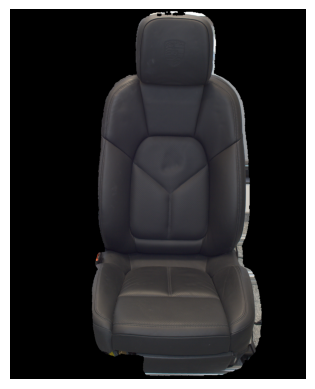

In [8]:
"""Workflow:
1. Converting disparity to 3D
Converts disparity values (pixel shifts between stereo images) to real-world depth (in meters).

2. Applying a transformation matrix (from ICP)
Back-projects each 2D pixel (u, v) to a 3D point (x, y, z) using the pinhole camera model.
Applies a rigid transformation (rotation + translation) to all 3D points.

3. Projecting back to 2D
Projects 3D points back to 2D image pixels using the camera intrinsics matrix K.

4. Warping the source image into the new view
For each transformed pixel, it copies the color from the original source image into a new blank canvas.
u_src, v_src are original pixel indices; u_proj, v_proj are where to place them after warping.
No interpolation → this creates black holes if pixels land sparsely or collide.

5. Filling in any holes caused by remapping gaps
Fills black pixels by copying color from surrounding pixels using morphological dilation.

# Inputs:
# - source_left_img
# - source_disp
# - transformation (from ICP)
# - K (camera intrinsics)
# - baseline (in meters)
"""

fx = K[0, 0]
T_scaled = transformation.copy()
scale = 5
T_scaled[:3, 3] *= scale

depth = disparity_to_depth(source_disp, K, distance_between_cameras)
points_3d = generate_3d_points(depth, K)
transformed_points = transform_points(points_3d, T_scaled)
u_proj, v_proj = project_3d_to_2d(transformed_points, K)

h, w = source_disp.shape
u_grid, v_grid = np.meshgrid(np.arange(w), np.arange(h))
warped_img = warp_image(source_left_img, u_proj, v_proj, u_grid.flatten(), v_grid.flatten(), (h, w))
warped_img = fill_black_pixels_with_dilation(warped_img)

# show the warped image
plt.imshow(cv2.cvtColor(warped_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

#### Compute pcd differences

In [9]:
def compute_pcd_differences(source: o3d.geometry.PointCloud,
                       reference: o3d.geometry.PointCloud,
                       max_dist: float = None) -> o3d.geometry.PointCloud:
    """
    Colors the `source` cloud based on distances to `reference`.
    Useful for heatmap-like visualization.
    """
    distances = np.asarray(source.compute_point_cloud_distance(reference))
    if max_dist is None:
        max_dist = np.percentile(distances, 95)  # Robust cap to remove outliers

    # Normalize and convert to colormap
    normalized = np.clip(distances / max_dist, 0, 1)
    cmap = plt.get_cmap("jet")
    colors = cmap(normalized)[:, :3]  # Remove alpha

    source_colored = copy.deepcopy(source)
    source_colored.colors = o3d.utility.Vector3dVector(colors)
    return source_colored

In [10]:
distance_pcd = compute_pcd_differences(aligned_source, target_pcd, max_dist=0.01)
o3d.visualization.draw_geometries([distance_pcd], window_name="Anomaly Map")